In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

(2000, 28, 28)


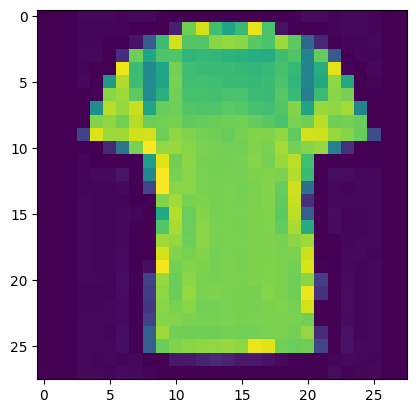

In [4]:
data_path='data'
#load the actual hackthon data (fashion-mnist)
images=np.load(data_path+'/images.npy')
labels=np.load(data_path+'/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1])

print(np.shape(images))

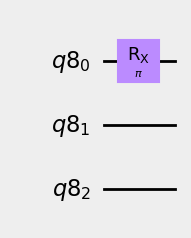

In [8]:
#your submission

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    q = qiskit.QuantumRegister(3)
    circuit = qiskit.QuantumCircuit(q)
    if image[0][0]==0:
        circuit.rx(np.pi,0)
    return circuit


def run_part2(image):

    #load the quantum classifier circuit
    classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')
    
    #encode image into circuit
    circuit=encode(image)
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))
    
    #simulate circuit
    histogram=simulate(qc)
        
    #convert histogram to category
    label=histogram_to_category(histogram)

    #thresholding the label, any way you want
    if label>0.5:
        label=1
    else:
        label=0
        
    return circuit,label
#score

classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')

classifier.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})

In [4]:
#how we grade your submission

score=0
gatecount=0
n=len(images)

for i in range(n):
    #run part 2
    circuit,label=run_part2(images[i])
    

    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #check label
    if label==labels[i]:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

1.0
